# Example 005: Using CMA-ES to perform previous optimizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import iddefix
from scipy.constants import c

## Example 1: Analytical Resonator Fitting

Example used from first example notebook

### Modelling a three resonator impedance spectrum by three arbitrary resonators

Any arbitrary number of resonators can be initialized. This is example will demonstrate the creation of three resonators with the resonator Formulas functions inside `iddeficx` and later fitting.

Three random resonators ($R_s$, Q, $f_r$):

1. 400 $\Omega$, 30, 0.2 GHz
2. 1000 $\Omega$, 10, 1 GHz
3. 500 $\Omega$, 20, 1.75 GHz

In [4]:
# Assigning the resonator parameters

parameters ={   '1': [400, 30, 0.2e9],
                '2': [1000, 10, 1e9],
                '3': [500, 20, 1.75e9],}

# Computing the impedance spectrum for the resonators

frequency = np.linspace(0, 2e9, 1000)

impedance = iddefix.Impedances.n_Resonator_longitudinal_imp(frequency, parameters)

#### Plotting the impedance spectrum

Plots of both the real- and imaginary part of the impedance, as well as the absolute of the complex impedance 

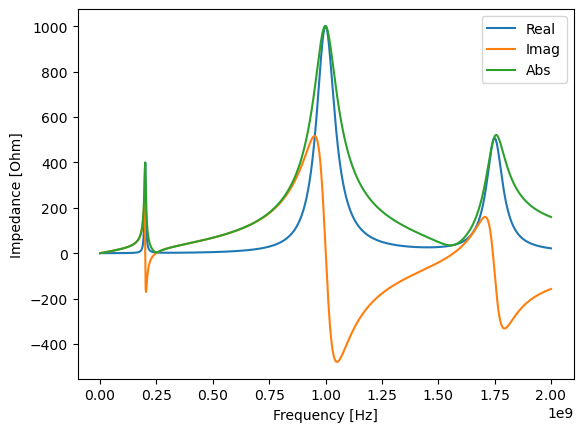

In [5]:
plt.plot(frequency, impedance.real, label='Real')
plt.plot(frequency, impedance.imag, label='Imag')
plt.plot(frequency, np.abs(impedance), label='Abs')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Impedance [Ohm]')
plt.legend()

### Fitting resonators with IDDEFIX on the absolute magnitude of the 3 resonator impdance spectrum

In [6]:
# Setting amount of resonators to fit

N_resonators = 3

# Bounds on resonators parameters
""" Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
ParameterBounds allows us to manually add a resonator with desired parameters """

parameterBounds = [(0, 2000), (1, 1e3), (0.1e9, 2e9),
                   (0, 2000), (1, 1e3), (0.1e9, 2e9),
                   (0, 2000), (1, 1e3), (0.1e9, 2e9)]

#### Running IDDEFIX CMA-ES
Running the CMA-ES algorithm with IDDEFIX and chosen parameters.

In [7]:
#%%time
DE_model = iddefix.EvolutionaryAlgorithm(frequency,
                                         impedance,
                                         N_resonators=N_resonators,
                                         parameterBounds=parameterBounds,
                                         plane="longitudinal",
                                         objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredError)

res = DE_model.run_cmaes(maxiter=500, popsize=50, sigma=0.15)
print(DE_model.warning)

[!] Using the fully decayed resonator formalism for impedance
9
Starting point: [1.000e+03 5.005e+02 1.050e+09 1.000e+03 5.005e+02 1.050e+09 1.000e+03
 5.005e+02 1.050e+09]
n_gen  |  n_eval  |     f_avg     |     f_min     |     sigma     | min_std  | max_std  |   axis  
     1 |        1 |  9.393002E+07 |  9.393002E+07 |  0.1500000000 |  0.15000 |  0.15001 |  1.00004
     2 |       51 |  9.215113E+07 |  8.321632E+07 |  0.1329663219 |  0.12232 |  0.14385 |  1.26240
     3 |      101 |  9.104420E+07 |  7.990429E+07 |  0.1257803548 |  0.10665 |  0.13664 |  1.36877
     4 |      151 |  9.001189E+07 |  7.990429E+07 |  0.1144207307 |  0.09104 |  0.12008 |  1.44811
     5 |      201 |  9.013349E+07 |  7.990429E+07 |  0.1204051138 |  0.08918 |  0.15460 |  1.94937
     6 |      251 |  8.904328E+07 |  7.839971E+07 |  0.1263775806 |  0.08679 |  0.16473 |  2.18092
     7 |      301 |  8.866488E+07 |  7.839971E+07 |  0.1289345314 |  0.08109 |  0.17141 |  2.41470
     8 |      351 |  8.793324E+07 |

### Assesing the fitting visually

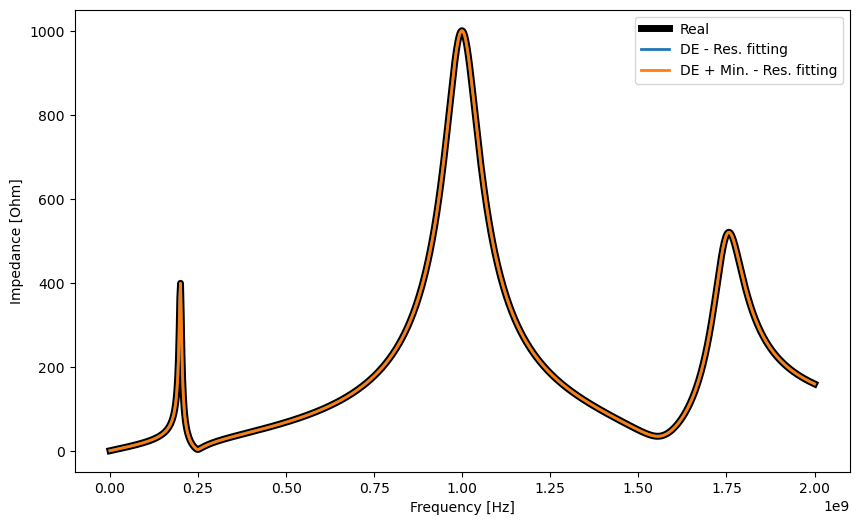

In [8]:
plt.figure(figsize=(10, 6))
result_DE = np.abs(DE_model.get_impedance(use_minimization=False))
result_DE_MIN = np.abs(DE_model.get_impedance())

plt.plot(frequency, np.abs(impedance), lw=5, label='Real', color='black')
plt.plot(frequency, result_DE,  lw=2, label='DE - Res. fitting')
plt.plot(frequency, result_DE_MIN,  lw=2, label='DE + Min. - Res. fitting')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Impedance [Ohm]')
plt.legend()